In [1]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne
from scipy.stats import f_oneway, ttest_ind




import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
from brokenaxes import brokenaxes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

from pandarallel import pandarallel
pandarallel.initialize()


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
tst_f = "/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat02/Epat02_10_FIAS_PDC.mat"
pat_obj = load_mat(tst_f)

In [3]:
DATA_DIR = "/mnt/ernie_main/Ghassan/ephys/data/periconnectivity"
color_map = COLOR_MAP
peri_fs = glob.glob(os.path.join(DATA_DIR, "peri_ictal_network_*pat*.csv"))
peri_fs

['/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat02.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat04.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat06.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat09.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat10.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat14.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat15.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat18.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat19.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat21.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_Epat23.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/

In [4]:
verbose_f =  '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_verbose_Epat09.csv'
tst = pd.read_csv(verbose_f)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/ernie_main/Ghassan/ephys/data/periconnectivity/peri_ictal_network_verbose_Epat09.csv'

In [5]:
grp_peri_dfs = []
check_list = []
for f in peri_fs:
    if "Spat18" in f or "Spat17" in f or "Epat20" in f:
        continue
    peri_df = pd.read_csv(f)
    try:
        peri_event_df = center_onset(peri_df)
        grp_peri_dfs.append(peri_event_df)
    except IndexError as e:
        print(f) 
        check_list.append(f)
grp_peri_dfs = pd.concat(grp_peri_dfs)

/tmp/ipykernel_10896/4080491313.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_10896/4080491313.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_10896/4080491313.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_10896/4080491313.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)
/tmp/ipykernel_10896/4080491313.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f)


In [59]:
def remap_ictal(win_sz_st_end, curr_label):
    """remaps the ictal period into early ictal and late ictal
    currently assumes that we've created a 30s seizure sub sampling 
    schema and that the early ictal will be 0-15
    and the late ictal will be 15-30"""
    if win_sz_st_end <15 and win_sz_st_end > 0:
        return "early_ictal"
    if win_sz_st_end <30 and win_sz_st_end >0:
        return "late_ictal"
    elif curr_label == 'early_post_ictal':
        return "post_ictal"
    return curr_label
grp_peri_dfs["win_2sz_label"] = grp_peri_dfs.apply(lambda row: remap_ictal(row['win_sz_st_end'], row['win_label']), axis =1)

In [6]:
print(f"Successfully loaded {len(set(grp_peri_dfs.patID))} patients records")
check_list

Successfully loaded 75 patients records


[]

In [60]:
grp_peri_dfs.win_2sz_label.unique()

array(['interictal', 'pre_ictal', 'early_ictal', 'late_ictal',
       'post_ictal', 'ictal', None], dtype=object)

In [42]:
tst_df= grp_peri_dfs[grp_peri_dfs.patID == 'Epat02']
tst_df = tst_df[tst_df.eventID == '11']
tst_df = tst_df[tst_df.freq_band == 'delta']
tst_df = tst_df[tst_df.region =='soz']
print(f'Window designations{tst_df.win_label.unique()}')
tst_df = tst_df[tst_df.win_label.isin(['early_ictal',  'ictal','late_ictal' ])]

Window designations['interictal' 'pre_ictal' 'early_ictal' 'ictal' 'late_ictal'
 'early_post_ictal' 'post_ictal']


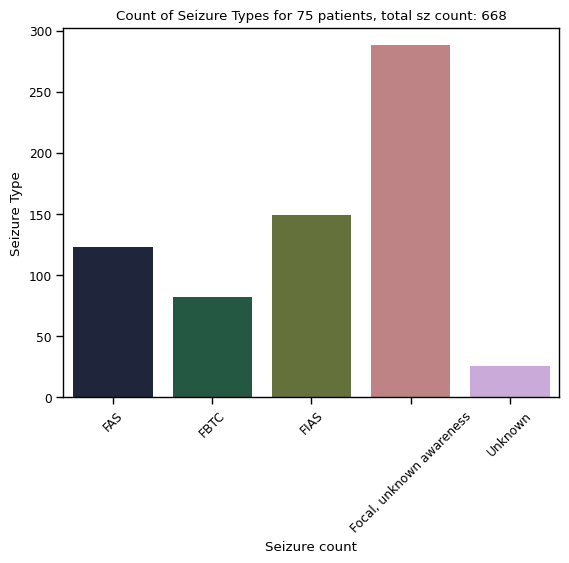

In [7]:
tmp_df = grp_peri_dfs[grp_peri_dfs.period ==0]
tmp_df  =tmp_df[tmp_df.region == 'soz']
tmp_df = tmp_df[tmp_df.freq_band == 'delta']
count_df = tmp_df[['eventID','patID','sz_type']].groupby(['sz_type']).count().reset_index()
total_sz = count_df.eventID.sum()
with sns.plotting_context("paper"):
    with sns.color_palette("cubehelix"):
        ax = sns.barplot(count_df, x='sz_type', y='eventID', hue="sz_type")
        _ = plt.xticks(rotation=45)
        _ = plt.title(f"Count of Seizure Types for 75 patients, total sz count: {total_sz}")
        plt.xlabel("Seizure count")
        plt.ylabel("Seizure Type")
        plt.savefig("../viz/sz_counts.svg", format='svg', dpi=600, transparent=True)



# Visualizing seizure-centered connectivity dynamics

In [8]:
grp_peri_dfs

,win_label,win_sz_st_end,sz_end,win_sz_centered,period,region,net_pdc,in_pdc,out_pdc,freq_band,window_designations,eventID,patID,sz_type
23490,interictal,-595.0,103,-595,0,soz,0.047351,0.108136,0.060785,delta,0.0_0.0_0.0,11,Epat02,FIAS
23491,interictal,-595.0,103,-595,0,pz,0.004617,0.080908,0.076291,delta,0.0_0.0_0.0,11,Epat02,FIAS
23492,interictal,-595.0,103,-595,0,nz,-0.005237,0.071754,0.076992,delta,0.0_0.0_0.0,11,Epat02,FIAS
23493,interictal,-595.0,103,-595,0,soz,0.047872,0.115380,0.067508,theta,0.0_0.0_0.0,11,Epat02,FIAS
23494,interictal,-595.0,103,-595,0,pz,0.004639,0.085224,0.080584,theta,0.0_0.0_0.0,11,Epat02,FIAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264451,post_ictal,NaN,19,613,1208,pz,0.025446,0.090431,0.064986,gamma_l,2.0_2.0_2.0,30,Spat48,"Focal, unknown awareness"
264452,post_ictal,NaN,19,613,1208,nz,-0.007624,0.061893,0.069517,gamma_l,2.0_2.0_2.0,30,Spat48,"Focal, unknown awareness"
264453,post_ictal,NaN,19,613,1208,soz,-0.000492,0.068582,0.069075,gamma_H,2.0_2.0_2.0,30,Spat48,"Focal, unknown awareness"
264454,post_ictal,NaN,19,613,1208,pz,0.029173,0.095480,0.066307,gamma_H,2.0_2.0_2.0,30,Spat48,"Focal, unknown awareness"


In [9]:
#Grouping across seizures on a per-patient level
# For every patient, along each region, in each frequency band, for all windows of time per seizure, group and get average values
tmp_df = grp_peri_dfs.dropna()
peri_stats_df = tmp_df[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_sz_st_end']].groupby(['patID','region','freq_band', 'win_sz_st_end',]).mean().reset_index()
peri_stats_df.shape[0]


1520634

In [10]:
peri_stats_df.head(5)

,patID,region,freq_band,win_sz_st_end,net_pdc,in_pdc,out_pdc
0,Epat02,nz,alpha,-595.0,-0.001985,0.072466,0.074450
1,Epat02,nz,alpha,-594.0,-0.002078,0.071453,0.073530
2,Epat02,nz,alpha,-593.0,-0.002462,0.070521,0.072983
3,Epat02,nz,alpha,-592.0,-0.002188,0.071400,0.073589
4,Epat02,nz,alpha,-591.0,-0.001999,0.070762,0.072761


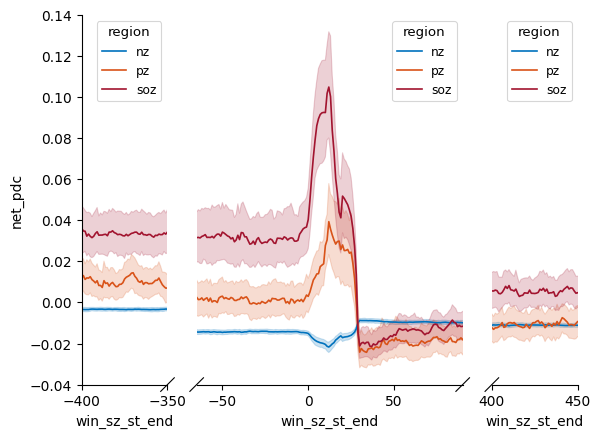

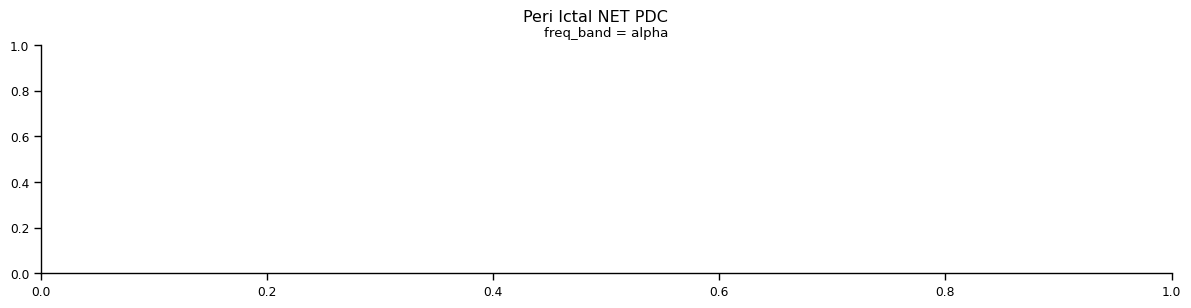

In [13]:
bax = brokenaxes(xlims=((-400,-350), (-65,90),(400,450)))
with sns.plotting_context("paper"):
  #  with sns.color_palette("tab10"):
    sns.set_palette(sns.color_palette(color_map.values()))
    plot_df = peri_stats_df[peri_stats_df.freq_band =='alpha']
    grid = sns.FacetGrid(plot_df, row='freq_band',row_order=['alpha',],aspect=4,palette=color_map) 
   # ax = grid.map_dataframe(sns.lineplot, y='net_pdc',x='win_sz_st_end', hue='region')
    axes = grid.axes
    for ax in bax.axs:
        sns.lineplot(data=plot_df,x='win_sz_st_end',y='net_pdc', hue='region',palette=color_map, ax=ax)
        # ax[0].vlines(x = [-60,0, 30, 90], ymin = -.05, ymax = .12,linestyles ='dashed')
    #plt.xlim(-100, 200)
    bax.axs[0].set_yticks(ax.get_yticks())

    # plt.suplabel("5s Windows (1s Strides)")
    grid.figure.suptitle("Peri Ictal NET PDC",y=1.01)
    plt.savefig("../viz/peri_Epat_FULL_peri_NETpdc_noNORM.pdf", format='pdf', transparent=True)


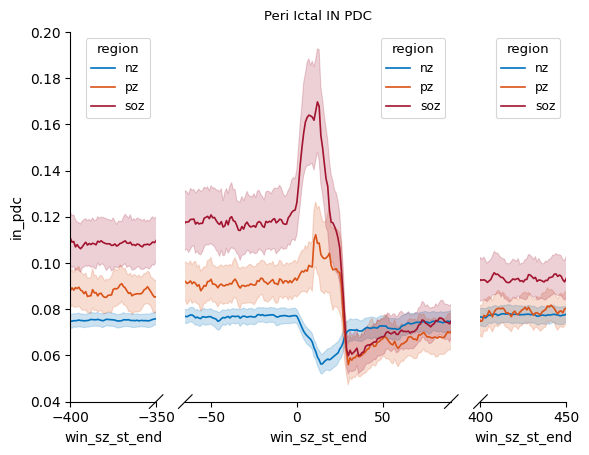

In [58]:
bax = brokenaxes(xlims=((-400,-350), (-65,90),(400,450)))
with sns.plotting_context("paper"):
    plot_df = peri_stats_df[peri_stats_df.freq_band =='alpha']
    for ax in bax.axs:
        sns.lineplot(data=plot_df,x='win_sz_st_end',y='in_pdc', hue='region',palette=color_map, ax=ax)
        # ax[0].vlines(x = [-60,0, 30, 90], ymin = -.05, ymax = .12,linestyles ='dashed')
    #plt.xlim(-100, 200)
    bax.axs[0].set_yticks(ax.get_yticks())
    # plt.suplabel("5s Windows (1s Strides)")
    plt.title("Peri Ictal IN PDC",y=1.01)
    plt.savefig("../viz/peri_Epat_FULL_peri_INpdc_noNORM.pdf",transparent=True)


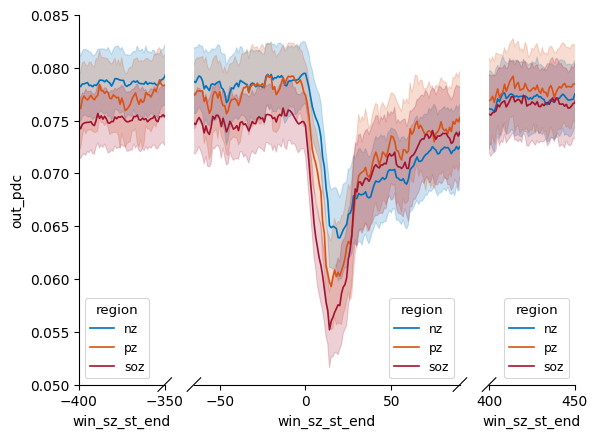

In [59]:
bax = brokenaxes(xlims=((-400,-350), (-65,90),(400,450)))
with sns.plotting_context("paper"):
    plot_df = peri_stats_df[peri_stats_df.freq_band =='alpha']
    for ax in bax.axs:
        sns.lineplot(data=plot_df,x='win_sz_st_end',y='out_pdc', hue='region',palette=color_map, ax=ax)
        # ax[0].vlines(x = [-60,0, 30, 90], ymin = -.05, ymax = .12,linestyles ='dashed')
    #plt.xlim(-100, 200)
    bax.axs[0].set_yticks(ax.get_yticks())
    plt.savefig("../viz/peri_Epat_FULL_peri_OUTpdc_zscore_noNORM.pdf",transparent=True)


TODO:
1. Zoom in on Pre-ictal Period, is anything significantly different during this period?
1. Compress timelines
1. Add significance testing for periods 

## Zooming in On the Pre-ictal Period

In [14]:
tmp_df = grp_peri_dfs[grp_peri_dfs.win_sz_st_end < 30]
tmp_df = tmp_df[tmp_df.win_label.isin(['interictal','pre_ictal','early_ictal', 'early_post_ictal'])].dropna()
peri_stats_df = tmp_df[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_sz_st_end']].groupby(['patID','region','freq_band', 'win_sz_st_end']).mean().reset_index()


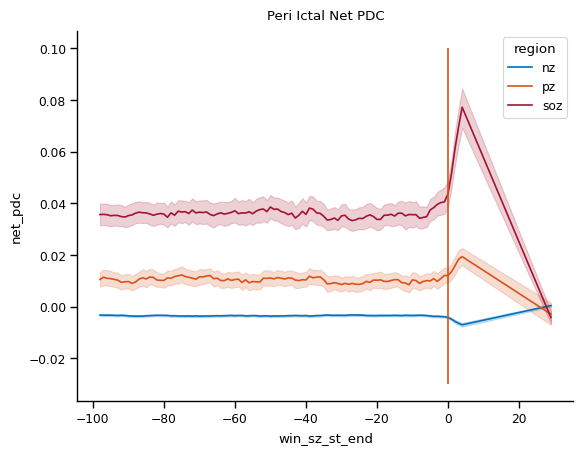

In [15]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.plotting_context("paper"):
        plot_df = peri_stats_df[peri_stats_df.win_sz_st_end >-99]
        # plot_df = plot_df[plot_df.win_sz_st_end>-100]
        ax = sns.lineplot(data=plot_df,y='net_pdc',x='win_sz_st_end', hue='region',  palette=color_map) 
        ax.vlines(x=[0], ymin=-.03,ymax=.1)
        # ax.hlines(y=[.035],xmin=-100, xmax=20)
        # ax.set(ylim=(-3, 20))
        sns.despine()
        plt.title("Peri Ictal Net PDC",y=1.01)
        plt.savefig("../viz/peri_Epat_zoom_preNET_0dc_zscore_noNORM.pdf",transparent=True)
        #plt.xticks(np.linspace(-600,400,3))


In [18]:
# windowsright up to 0_0_1 seem to be changing to gear up for a seizure
#TODO examine this super zoomed in window

In [62]:
#Melting peri_connectivity_df into windows
tmp_df = grp_peri_dfs.dropna()
window_stats_df = tmp_df[['region','net_pdc','in_pdc','out_pdc','freq_band','patID','win_2sz_label']].groupby(['patID','region','freq_band', 'win_2sz_label']).mean().reset_index()
window_stats_df = window_stats_df.melt(id_vars=['patID','region','freq_band','win_2sz_label',], value_vars=['net_pdc','in_pdc','out_pdc'],value_name='strength', var_name='connectivity')
window_stats_df.head()


,patID,region,freq_band,win_2sz_label,connectivity,strength
0,Epat02,nz,alpha,early_ictal,net_pdc,-0.009257
1,Epat02,nz,alpha,interictal,net_pdc,-0.001553
2,Epat02,nz,alpha,late_ictal,net_pdc,-0.000986
3,Epat02,nz,alpha,post_ictal,net_pdc,0.000125
4,Epat02,nz,alpha,pre_ictal,net_pdc,-0.002226


In [66]:
COLOR_MAP

{'pz': '#D95319',
 'soz': '#A2142F',
 'nz': '#0072BD',
 'niz': '#0072BD',
 'pz_soz': '#D95319',
 'soz_soz': '#A2142F',
 'nz_soz': '#0072BD',
 'niz_soz': '#A2142F',
 'niz_pz': '#D95319',
 'niz_niz': '#0072BD',
 'PZ': '#D95319',
 'SOZ': '#A2142F',
 'NZ': '#0072BD',
 'NIZ': '#0072BD',
 'PZ_SOZ': '#D95319',
 'SOZ_SOZ': '#A2142F',
 'NZ_SOZ': '#0072BD',
 'NIZ_SOZ': '#A2142F',
 'NIZ_PZ': '#D95319',
 'NIZ_NIZ': '#0072BD',
 'SOZ_False': '#c28893',
 'SOZ_True': '#A2142F',
 'PZ_False': '#dba38a',
 'PZ_True': '#D95319',
 'NIZ_False': '#84a2b5',
 'NIZ_True': '#0072BD'}

In [21]:
# tmp_df = window_stats_df[window_stats_df.freq_band == 'gamma_H']
# tmp_df[['region','freq_band','connectivity', 'win_label','strength']].groupby(['region','freq_band','connectivity', 'win_label']).mean()

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#d95319'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#d95319'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#d95319'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and w

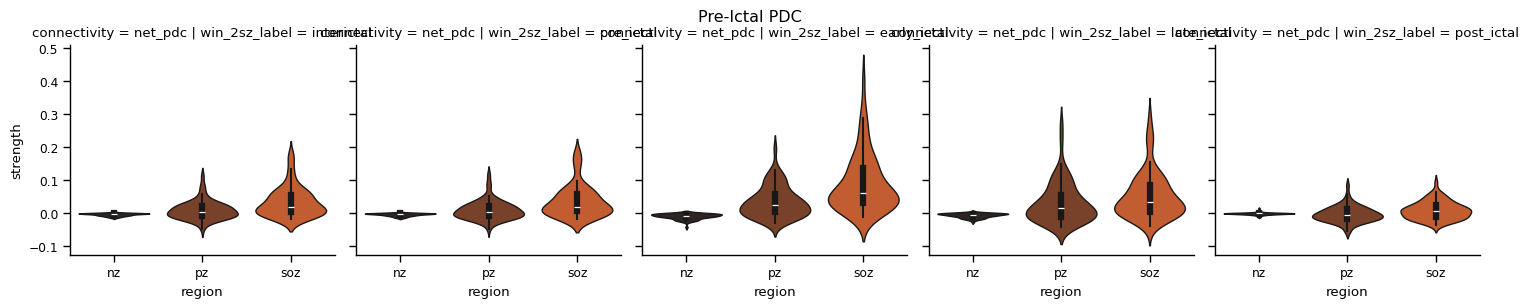

In [67]:
with sns.plotting_context("paper"):
        plot_df = window_stats_df[window_stats_df.freq_band =='alpha']
        ## NOTE: combining windows here to match designations inter, pre, early-ictal, late_ictal, post_ictal
        grid = sns.FacetGrid(plot_df, row='connectivity',row_order=['net_pdc' ],
                             col='win_2sz_label', 
                             col_order=['interictal', 'pre_ictal','early_ictal','late_ictal','post_ictal'],
                             palette=COLOR_MAP) 
        ax = grid.map_dataframe(sns.violinplot, y='strength',x='region', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Pre-Ictal PDC",y=1.01)
        plt.savefig("../viz/peri_alpha_lanterns.pdf", transparent=True)


### Significance Testing
Significance Testing these periods. Want to know if SOZ NIZ and PZ are distinguishable in all 3 periods and also want to know if the connectivity between each period changes significantly.

In [ ]:
# add SOZ to NIZ to PZ ttest-ing


In [68]:
# Changes between Periods for Net connectivity
stats_df = window_stats_df[window_stats_df.freq_band =='alpha']
stats_df = stats_df[stats_df.connectivity == 'net_pdc']
windows = list(set(stats_df.win_2sz_label))
n = len(windows)
nz_sig_matrix = np.ones((n,n))
pz_sig_matrix = np.ones((n,n))
soz_sig_matrix = np.ones((n,n))
regional_sig_diff = dict()

for i, win_2sz_label in enumerate(windows):
    for j, comp_win in enumerate(windows):
        if i == j:
            continue
        win_df = stats_df[stats_df.win_2sz_label == win_2sz_label]
        comp_df = stats_df[stats_df.win_2sz_label == comp_win]

        #Get net connectivity for each region during this window
        soz_win, soz_comp = win_df[win_df.region == 'soz'].strength, comp_df[comp_df.region =='soz'].strength
        pz_win, pz_comp = win_df[win_df.region == 'pz'].strength, comp_df[comp_df.region =='pz'].strength
        nz_win, nz_comp = win_df[win_df.region == 'nz'].strength, comp_df[comp_df.region =='nz'].strength

        nz_sig_matrix[i,j] = ttest_ind(nz_win, nz_comp,permutations=100)[1]
        
        soz_sig_matrix[i,j] = ttest_ind(soz_win, soz_comp,permutations=100)[1]
        pz_sig_matrix[i,j] = ttest_ind(pz_win, pz_comp,permutations=100)[1]
    _, p = f_oneway(soz_win, pz_win,nz_win)
    if p <.05: 
        print(f"In window {win_2sz_label} all 3 regions' net connectivity appears to be significantly different\n with p_value:{p}")
        reg_keys, regional_sig_diff[win_2sz_label] = paried_region_significance({'soz':soz_win, 'nz':nz_win, 'pz':pz_win})
        print(reg_keys)

#Setting multiple comparison cut off for significance result
cutoff = .05 / 3*6*6
#highlighting significant entries in the matrix 
og_sig_matrix= copy.copy(soz_sig_matrix)
print(f"SOZ SIG matrix values:\n {soz_sig_matrix}")
soz_sig_matrix[soz_sig_matrix > cutoff] =1
soz_sig_matrix[soz_sig_matrix <= cutoff] =0
#1 - matrix so that significant entries can show up as bright on heatmap (heatmap is of indicators)
soz_win_df = pd.DataFrame(data=1-soz_sig_matrix,columns=windows, index=windows)


print(f"\n\nNIZ SIG matrix values:\n {nz_sig_matrix}")
nz_sig_matrix[nz_sig_matrix > cutoff] =1
nz_sig_matrix[nz_sig_matrix <= cutoff] =0
nz_win_df = pd.DataFrame(data=1-nz_sig_matrix,columns=windows, index=windows)

print(f"\n\nPZ SIG matrix values:\n {pz_sig_matrix}")

pz_sig_matrix[pz_sig_matrix > cutoff] =1
pz_sig_matrix[pz_sig_matrix <= cutoff] =0
pz_win_df = pd.DataFrame(data=1-pz_sig_matrix,columns=windows, index=windows)


In window pre_ictal all 3 regions' net connectivity appears to be significantly different
 with p_value:4.830361242765358e-12
['soz', 'nz', 'pz']
In window interictal all 3 regions' net connectivity appears to be significantly different
 with p_value:5.875190967961903e-12
['soz', 'nz', 'pz']
In window post_ictal all 3 regions' net connectivity appears to be significantly different
 with p_value:0.0016617693087715472
['soz', 'nz', 'pz']
In window early_ictal all 3 regions' net connectivity appears to be significantly different
 with p_value:2.1118606668041657e-20
['soz', 'nz', 'pz']
In window late_ictal all 3 regions' net connectivity appears to be significantly different
 with p_value:2.587722676696948e-10
['soz', 'nz', 'pz']
SOZ SIG matrix values:
 [[1.         0.77227723 0.00990099 0.00990099 0.0990099 ]
 [0.83168317 1.         0.00990099 0.00990099 0.06930693]
 [0.00990099 0.00990099 1.         0.00990099 0.00990099]
 [0.00990099 0.00990099 0.00990099 1.         0.00990099]
 [0.0693

In [72]:
soz_win_df = pd.DataFrame(data=og_sig_matrix,columns=windows, index=windows)
windows

['interictal',
 'pre_ictal',
 'post_ictal',
 'early_ictal',
 'ictal',
 'late_ictal',
 'early_post_ictal']

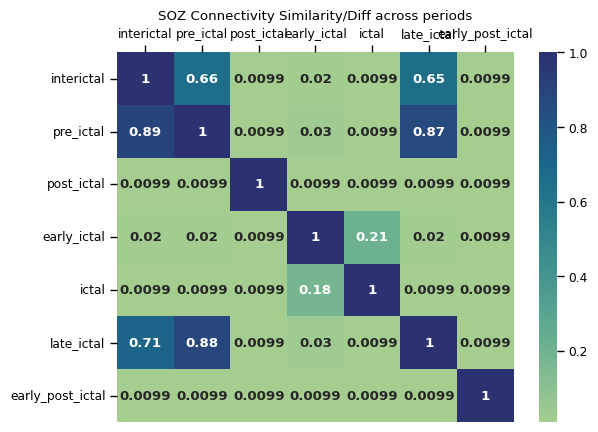

In [77]:
with sns.plotting_context("paper"):
    ax = sns.heatmap(soz_win_df,annot=True,cmap="crest", annot_kws={"weight":"bold"})
    ax.xaxis.tick_top()
    plt.title("SOZ Connectivity Similarity/Diff across periods")
    plt.savefig("../viz/interperiod_soz_self_similarity.pdf",transparent=True)


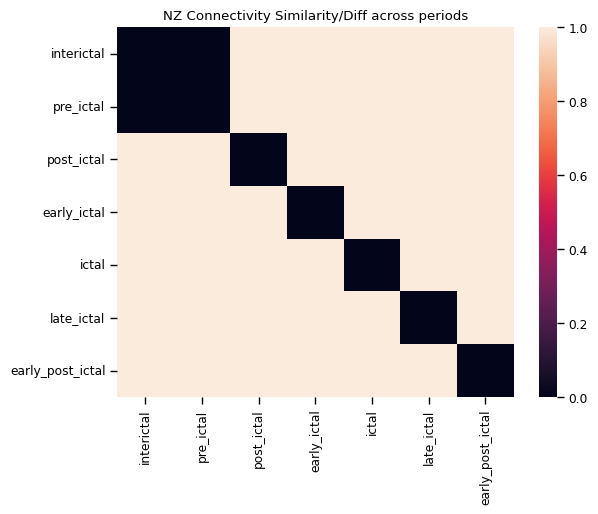

In [47]:
with sns.plotting_context("paper"):
    sns.heatmap(nz_win_df)
    plt.title("NZ Connectivity Similarity/Diff across periods")
    plt.savefig("../viz/interperiod_nz_self_similarity.pdf",transparent=True)
    #Put stars in the boxes that correspond to p-vals
    #remove coloar bar

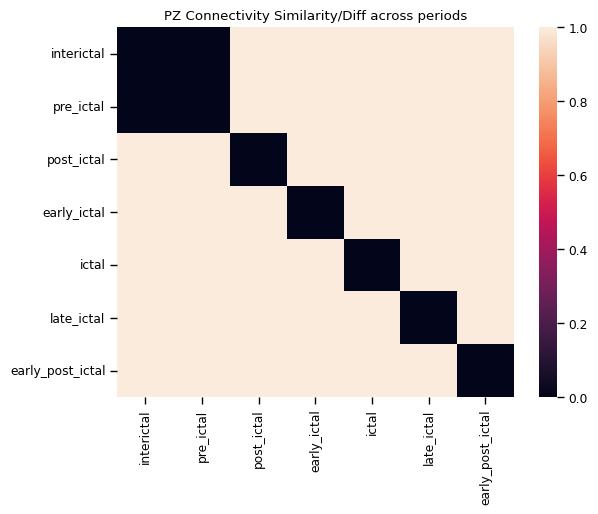

In [48]:
with sns.plotting_context("paper"):
    sns.heatmap(pz_win_df)
    plt.title("PZ Connectivity Similarity/Diff across periods")
    plt.savefig("../viz/interperiod_PZ_self_similarity.pdf",transparent=True)

In [69]:
reg_sig_df = []
for period, sig_mat in regional_sig_diff.items():
    df = pd.DataFrame(data=sig_mat,columns=reg_keys, index=reg_keys)
    df['period'] = period
    reg_sig_df.append(df)
reg_sig_df = pd.concat(reg_sig_df)
reg_sig_df

,soz,nz,pz,period
soz,1.000000,0.009901,0.009901,pre_ictal
nz,0.009901,1.000000,0.009901,pre_ictal
pz,0.009901,0.009901,1.000000,pre_ictal
soz,1.000000,0.009901,0.009901,interictal
nz,0.009901,1.000000,0.009901,interictal
pz,0.009901,0.009901,1.000000,interictal
soz,1.000000,0.009901,0.029703,post_ictal
nz,0.019802,1.000000,0.673267,post_ictal
pz,0.019802,0.623762,1.000000,post_ictal
soz,1.000000,0.009901,0.009901,early_ictal


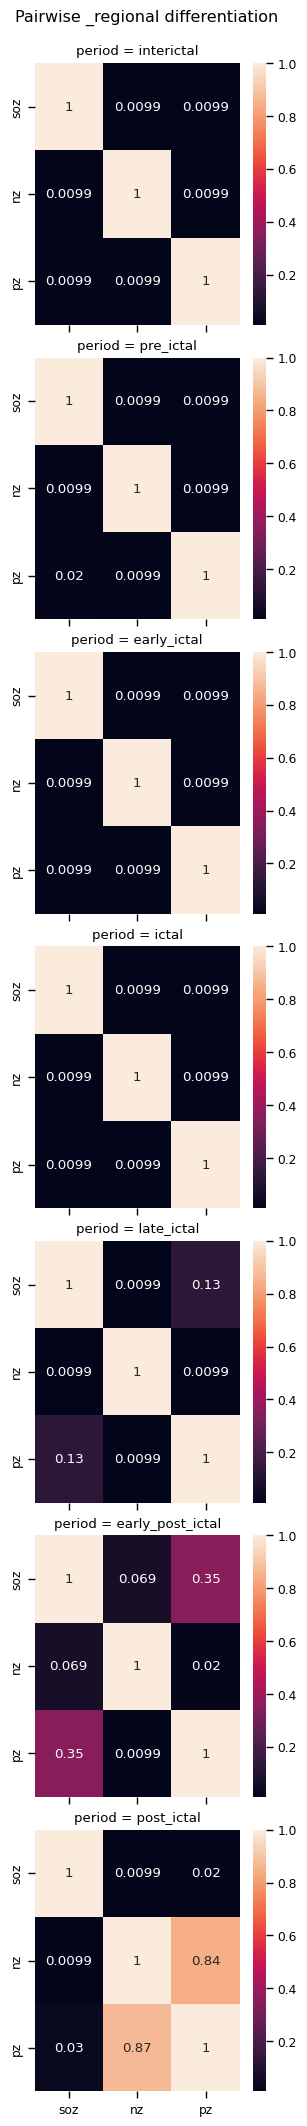

In [45]:
with sns.plotting_context("paper"):
        plot_df = reg_sig_df
        grid = sns.FacetGrid(plot_df, row='period',
                             row_order=['interictal', 'pre_ictal','early_ictal','ictal','late_ictal','early_post_ictal','post_ictal']
        )
        def draw_heatmap(*args, **kwargs):
                data = kwargs.pop("data")
                sns.heatmap(data.drop('period',axis=1),annot=True)
        ax = grid.map_dataframe(draw_heatmap)
        grid.add_legend()
        grid.figure.suptitle("Pairwise _regional differentiation ",y=1.01)
        plt.savefig("../viz/peri_regional diff _ttest.pdf", transparent=True)

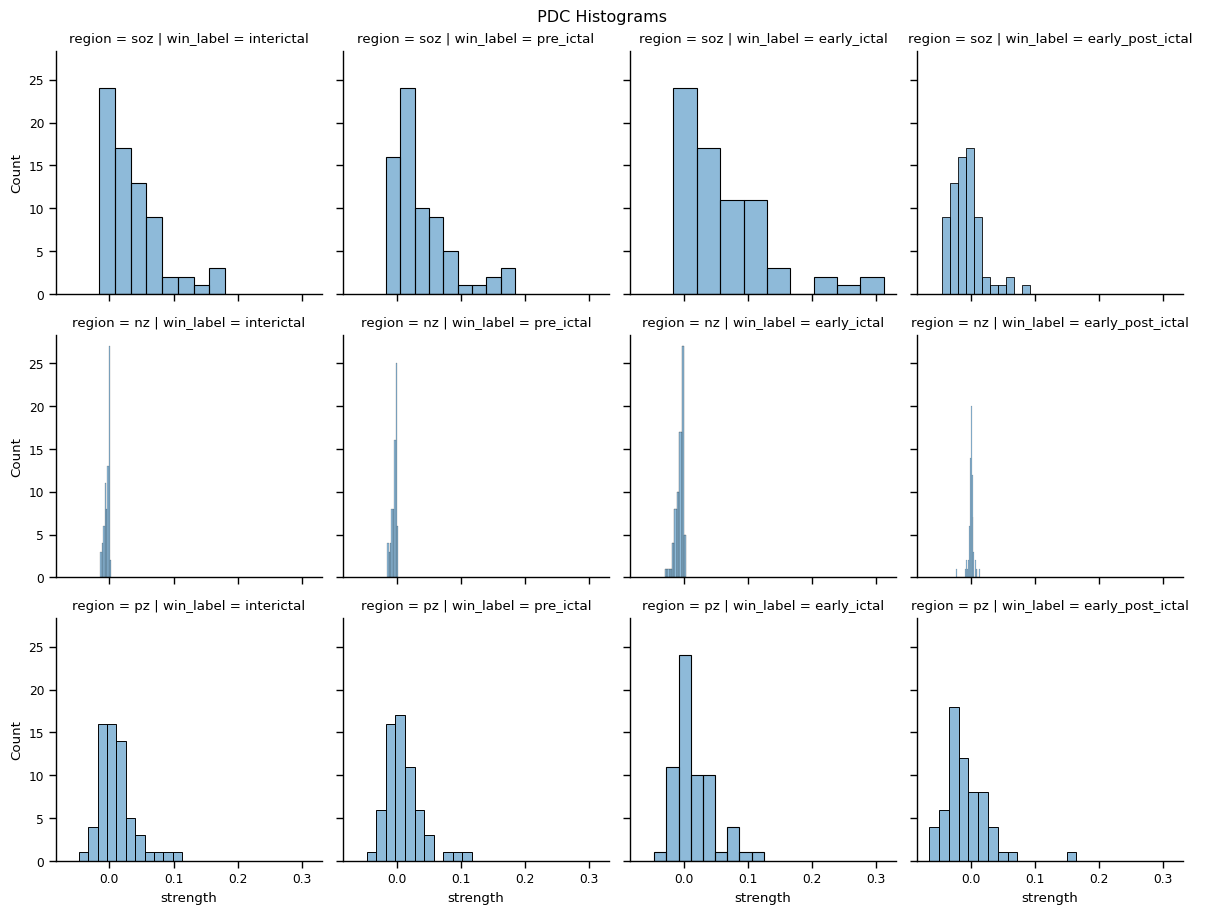

In [29]:
stats_df = window_stats_df[window_stats_df.freq_band =='alpha']
stats_df = stats_df[stats_df.connectivity == 'net_pdc']
with sns.plotting_context("paper"):
        plot_df = stats_df
        grid = sns.FacetGrid(plot_df, row='region',row_order=['soz', 'nz','pz'],col='win_label', col_order=['interictal','pre_ictal','early_ictal', 'early_post_ictal']) 
        ax = grid.map_dataframe(sns.histplot,x='strength', hue='region',)
        grid.add_legend()
        print(f"SOZ SIG matrix values: {soz_sig_matrix}")
        plt.savefig("SOZ pdc dists.pdf", transparent=True)
